In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_selection import SequentialFeatureSelector

In [50]:
# Load data
df = pd.read_csv('creditCardData.csv')
df

,id,age,education,marriage,owned_rent,credit_limit,payment_status_1,payment_status_2,payment_status_3,due_amt1,due_amt2,due_amt3,payment_amt1,payment_amt2,payment_amt3,default
0,1,57,2,1,1,50000,-1,0,-1,8617,5670,35835,2000,36681,10000,0
1,2,51,1,2,2,260000,-1,-1,-1,12261,21670,9966,21818,9966,8583,0
2,3,26,2,2,2,70000,2,0,0,41087,42445,45020,2007,3582,0,1
3,4,23,1,2,1,90000,0,0,0,4744,7070,0,5757,0,5398,0
4,5,27,1,2,1,60000,1,-2,-1,-109,-425,259,0,1000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,316,34,2,1,2,150000,2,2,2,39465,42829,41845,4000,0,2000,1
316,317,65,3,2,2,80000,0,0,0,84985,84247,81619,4000,2048,1300,0
317,318,33,2,2,1,10000,-2,-2,-2,0,0,0,0,0,0,0
318,319,41,2,1,2,170000,0,-1,-1,21170,9698,7360,9734,7373,6380,0


## Feature Engineering

In [51]:
# Feature Engineering: create new features
df['worst_pay_status'] = df[['payment_status_1', 'payment_status_2', 'payment_status_3']].max(axis=1)

# Create 'continuous_delinquency' as a binary feature
df['continuous_delinquency'] = (
    (df['payment_status_1'] >= 2) & 
    (df['payment_status_2'] >= 2) & 
    (df['payment_status_3'] >= 2)
).astype(int)

# Create 'avg_pay_ratio'
df['avg_pay_ratio'] = (df['payment_amt1'] + df['payment_amt2'] + df['payment_amt3']) / (
    df['due_amt1'] + df['due_amt2'] + df['due_amt3']
)

# Replace infinite values and fill missing values with median
df['avg_pay_ratio'] = df['avg_pay_ratio'].replace([float('inf'), -float('inf')], None).fillna(df['avg_pay_ratio'].median()).astype(float)

In [52]:
# Drop unnecessary columns
df.drop("id", axis = 1, inplace = True)

## One-hot Encoding

In [53]:
# Convert to categorical features
df['education'] = df['education'].astype('category')
df['marriage'] = df['marriage'].astype('category')
df['owned_rent'] = df['owned_rent'].astype('category')

categorical_features = ['education', 'marriage', 'owned_rent']

# One-hot encode categorical features
encoded_df = df.copy()
encoded_df.drop(categorical_features, axis = 1, inplace = True)

dummies = pd.get_dummies(df[categorical_features], drop_first = True, dtype = "int")
encoded_df = pd.concat([encoded_df, dummies], axis = 1)
encoded_df

,age,credit_limit,payment_status_1,payment_status_2,payment_status_3,due_amt1,due_amt2,due_amt3,payment_amt1,payment_amt2,...,worst_pay_status,continuous_delinquency,avg_pay_ratio,education_2,education_3,education_4,education_5,marriage_2,marriage_3,owned_rent_2
0,57,50000,-1,0,-1,8617,5670,35835,2000,36681,...,0,0,0.971250,1,0,0,0,0,0,0
1,51,260000,-1,-1,-1,12261,21670,9966,21818,9966,...,-1,0,0.919584,0,0,0,0,1,0,1
2,26,70000,2,0,0,41087,42445,45020,2007,3582,...,2,0,0.043477,1,0,0,0,1,0,1
3,23,90000,0,0,0,4744,7070,0,5757,0,...,0,0,0.944219,0,0,0,0,1,0,0
4,27,60000,1,-2,-1,-109,-425,259,0,1000,...,1,0,-3.636364,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,34,150000,2,2,2,39465,42829,41845,4000,0,...,2,1,0.048333,1,0,0,0,0,0,1
316,65,80000,0,0,0,84985,84247,81619,4000,2048,...,0,0,0.029292,0,1,0,0,1,0,1
317,33,10000,-2,-2,-2,0,0,0,0,0,...,-2,0,0.064697,1,0,0,0,1,0,0
318,41,170000,0,-1,-1,21170,9698,7360,9734,7373,...,0,0,0.614393,1,0,0,0,0,0,1


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   age                     320 non-null    int64   
 1   education               320 non-null    category
 2   marriage                320 non-null    category
 3   owned_rent              320 non-null    category
 4   credit_limit            320 non-null    int64   
 5   payment_status_1        320 non-null    int64   
 6   payment_status_2        320 non-null    int64   
 7   payment_status_3        320 non-null    int64   
 8   due_amt1                320 non-null    int64   
 9   due_amt2                320 non-null    int64   
 10  due_amt3                320 non-null    int64   
 11  payment_amt1            320 non-null    int64   
 12  payment_amt2            320 non-null    int64   
 13  payment_amt3            320 non-null    int64   
 14  default                 32

## Exploratory Data Analysis (EDA)

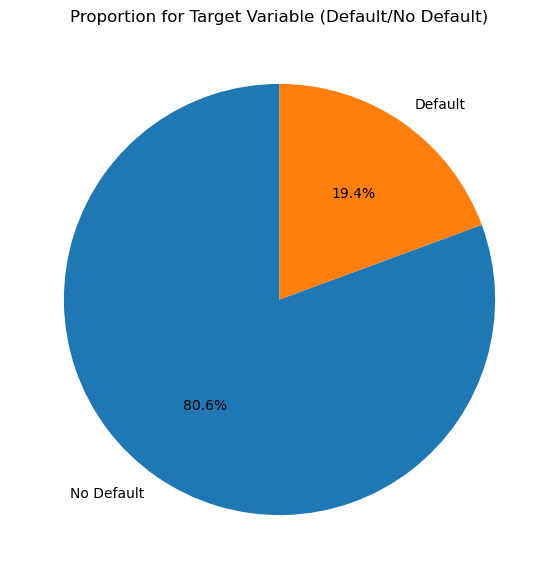

In [55]:
# Count the occurrences of each class (0 and 1)
counts = df["default"].value_counts()

# Define labels for the pie chart (e.g., "Class 0" and "Class 1")
labels = ["No Default", "Default"]

# Create the pie chart
plt.figure(figsize = (7, 7))
plt.pie(counts, labels = labels, autopct = "%1.1f%%", startangle = 90)
plt.title("Proportion for Target Variable (Default/No Default)")
plt.show()

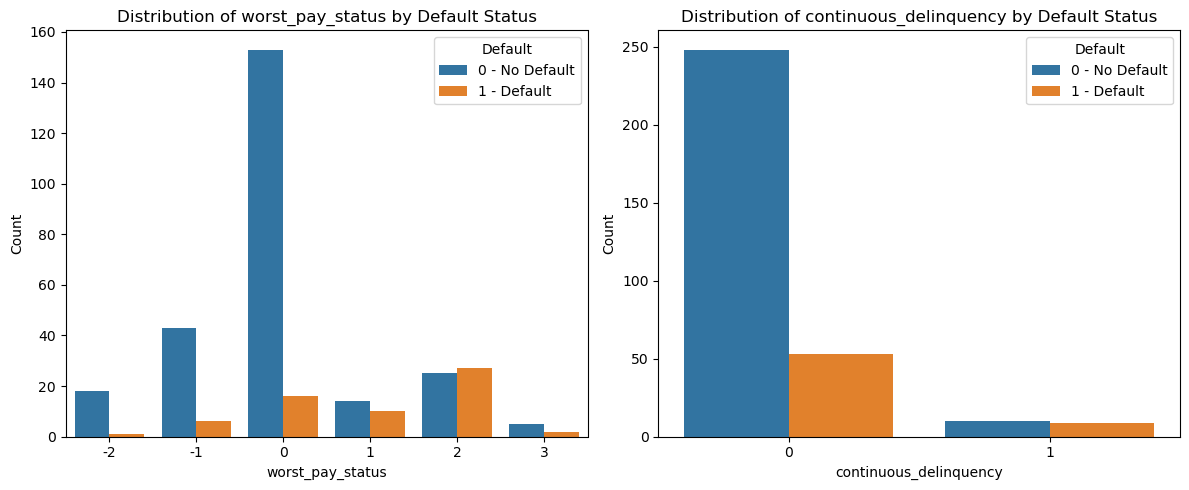

Percentage distribution for worst_pay_status:
default                0       1
worst_pay_status                
-2                94.74%   5.26%
-1                87.76%  12.24%
 0                90.53%   9.47%
 1                58.33%  41.67%
 2                48.08%  51.92%
 3                71.43%  28.57%
 
Percentage distribution for continuous_delinquency:
default                      0       1
continuous_delinquency                
0                       82.39%  17.61%
1                       52.63%  47.37%
 


In [56]:
df['worst_pay_status'] = df['worst_pay_status'].astype('category')
df['continuous_delinquency'] = df['continuous_delinquency'].astype('category')

categorical_features = ['worst_pay_status', 'continuous_delinquency']

# Set up the figure and axes for 1 row x 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Wider figure for better spacing

# Plot each categorical feature
for idx, feature in enumerate(categorical_features):
    ax = axes[idx]
    total = len(df)

    # Countplot by feature and hue='default'
    sns.countplot(data=df, x=feature, hue='default', ax=ax)

    ax.set_title(f'Distribution of {feature} by Default Status')
    ax.set_ylabel('Count')
    ax.set_xlabel(feature)

    # Commented out bar labels to avoid showing data values on bars
    # for container in ax.containers:
    #     ax.bar_label(container, fmt='%d', fontsize=9)

    # Set legend
    ax.legend(title='Default', labels=['0 - No Default', '1 - Default'])

plt.tight_layout()
plt.show()

# Loop through each categorical feature and print percentage breakdown
for cat_feature in categorical_features:
    counts = df.groupby(cat_feature, observed=True)['default'].value_counts(normalize=True).unstack().fillna(0) * 100
    counts = counts.round(2).astype(str) + "%"
    
    print(f"Percentage distribution for {cat_feature}:")
    print(counts.to_string())
    print(" ")

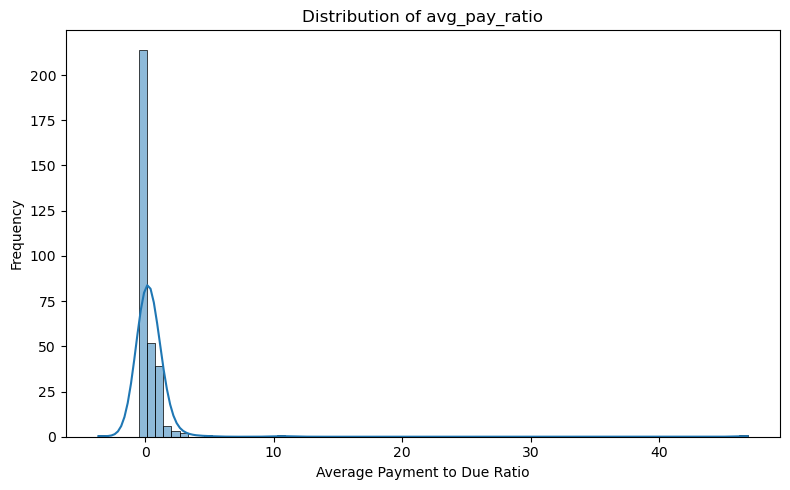

In [57]:
# Plot the distribution for AVG_PAY_RATIO
plt.figure(figsize=(8,5))
sns.histplot(data=encoded_df, x='avg_pay_ratio', bins=80, kde=True)
plt.title('Distribution of avg_pay_ratio')
plt.xlabel('Average Payment to Due Ratio')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

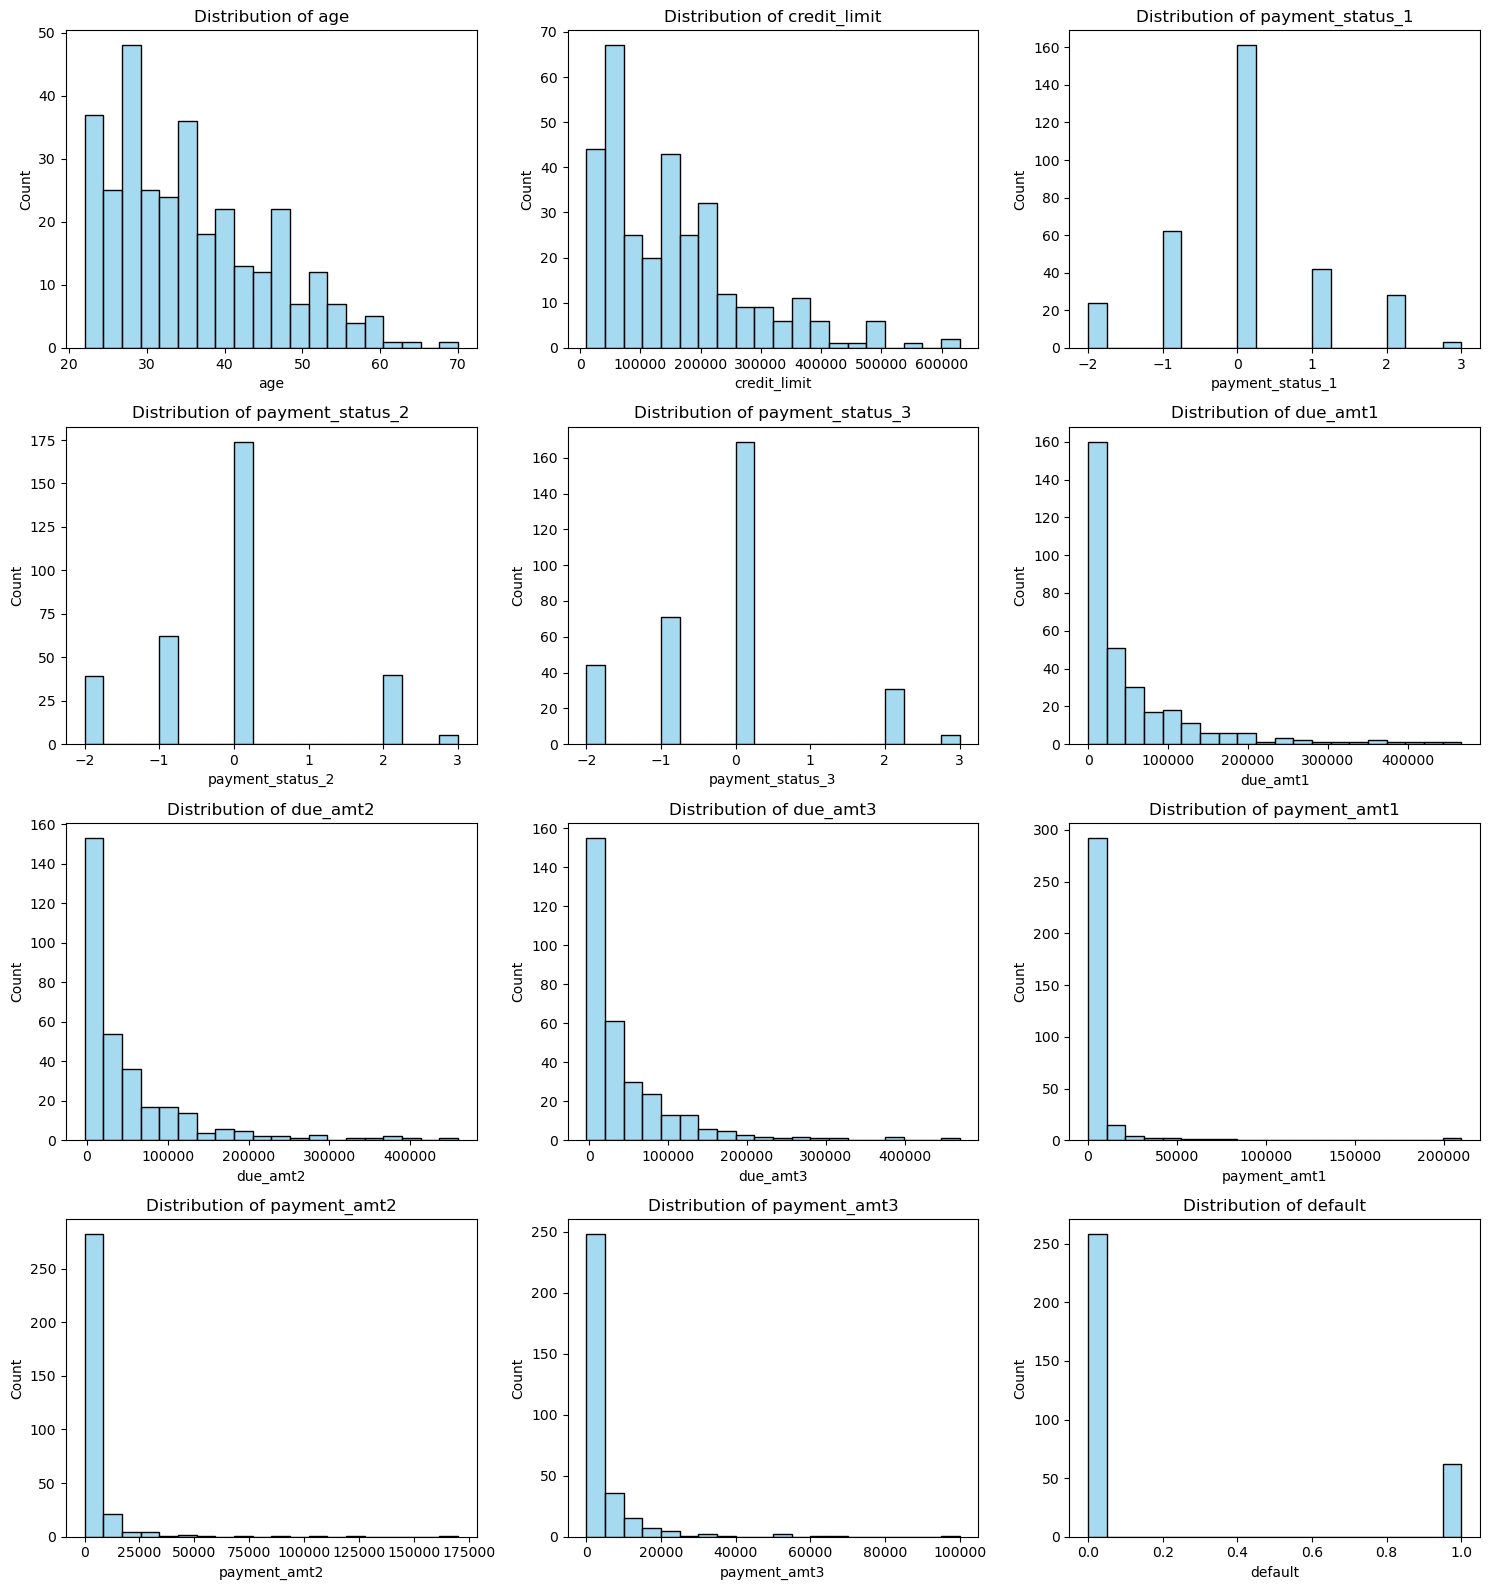

In [58]:
# Filter for int64 columns
int64_features = df.select_dtypes(include='int64').columns.tolist()

# Set up subplot grid
num_features = len(int64_features)
cols = 3  # number of plots per row
rows = (num_features + cols - 1) // cols

plt.figure(figsize=(5 * cols, 4 * rows))

# Plot each int64 feature as a histogram
for i, feature in enumerate(int64_features, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df[feature], kde=False, bins=20, color='skyblue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [59]:
log_features = ['credit_limit', 'due_amt1', 'due_amt2', 'due_amt3', 
                'payment_amt1', 'payment_amt2', 'payment_amt3']

# Apply log1p (log(x + 1)) transformation
encoded_df[log_features] = encoded_df[log_features].apply(np.log1p)

In [61]:
# Drop rows with NaNs in due_amt1, due_amt2, or due_amt3
encoded_df = encoded_df.dropna(subset=['due_amt1', 'due_amt2', 'due_amt3'])

,age,credit_limit,payment_status_1,payment_status_2,payment_status_3,due_amt1,due_amt2,due_amt3,payment_amt1,payment_amt2,...,worst_pay_status,continuous_delinquency,avg_pay_ratio,education_2,education_3,education_4,education_5,marriage_2,marriage_3,owned_rent_2
0,57,10.819798,-1,0,-1,9.061608,8.643121,10.486708,7.601402,10.510041,...,0,0,0.971250,1,0,0,0,0,0,0
1,51,12.468441,-1,-1,-1,9.414260,9.983730,9.207035,9.990536,9.207035,...,-1,0,0.919584,0,0,0,0,1,0,1
2,26,11.156265,2,0,0,10.623471,10.655988,10.714884,7.604894,8.183956,...,2,0,0.043477,1,0,0,0,1,0,1
3,23,11.407576,0,0,0,8.464847,8.863757,0.000000,8.658345,0.000000,...,0,0,0.944219,0,0,0,0,1,0,0
5,26,10.819798,0,0,0,9.637567,9.715711,9.769785,7.313887,7.313887,...,0,0,0.080972,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,34,11.849405,-1,-1,-1,6.066108,6.066108,6.555357,6.066108,6.555357,...,-1,0,1.000000,1,0,0,0,0,0,0
315,34,11.918397,2,2,2,10.583195,10.664994,10.641751,8.294300,0.000000,...,2,1,0.048333,1,0,0,0,0,0,1
316,65,11.289794,0,0,0,11.350242,11.341520,11.309830,8.294300,7.625107,...,0,0,0.029292,0,1,0,0,1,0,1
317,33,9.210440,-2,-2,-2,0.000000,0.000000,0.000000,0.000000,0.000000,...,-2,0,0.064697,1,0,0,0,1,0,0


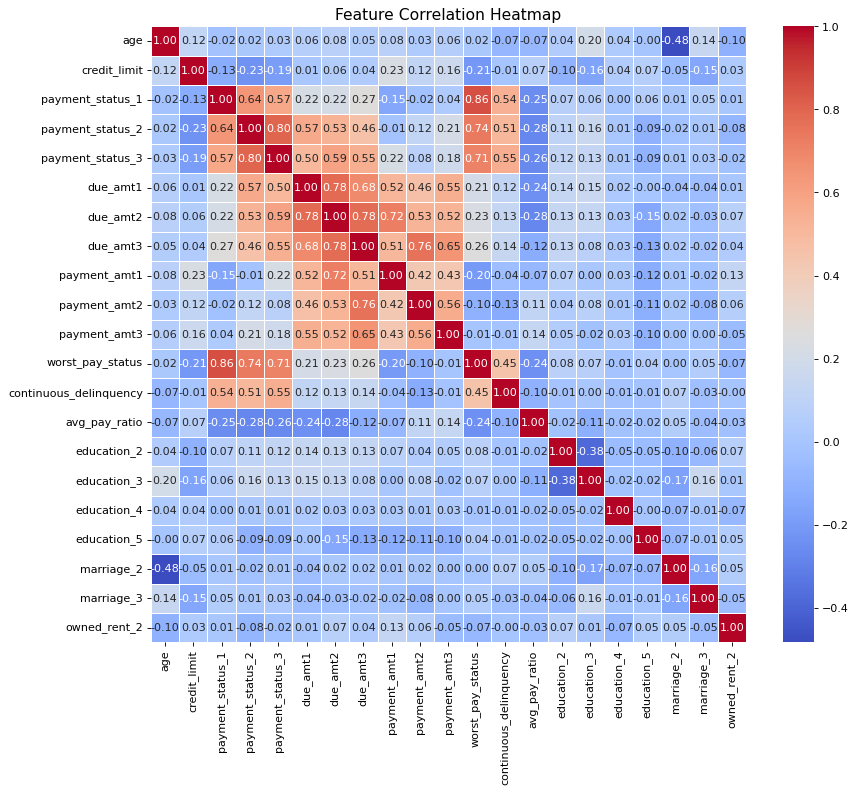

In [62]:
# Compute the correlation matrix for all features (with encoding)
corr_matrix = encoded_df.drop(columns = ["default"]).corr()

# Plot the heatmap
plt.figure(figsize = (12, 10), dpi = 80)
sns.heatmap(corr_matrix, annot = True, fmt = ".2f", cmap = "coolwarm", linewidths = 0.5)
plt.title("Feature Correlation Heatmap", fontsize = 14)
plt.show()

In [64]:
# List of redundant or highly correlated features to drop
drop_features = [
    'due_amt2', 'due_amt3',
    'payment_status_1', 'payment_status_2', 'payment_status_3',
    'payment_amt2', 'payment_amt3'
]

# Drop the selected features from the dataset
encoded_df = encoded_df.drop(columns=drop_features)

## Predictive Analytics

In [66]:
# Define feature matrix X and target variable y
X = encoded_df.drop(columns=['default'])
y = encoded_df[['default']]

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Baseline Logistic Regression

In [67]:
# Initialize logistic regression model
lr = LogisticRegression()

# Define hyperparameter grid
param_grid = {'max_iter': [100, 200, 300]}

# Set up GridSearchCV with AUC as the scoring metric
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='roc_auc')

# Fit GridSearchCV on the training set
grid_search.fit(X_train_scaled, y_train.values.ravel())

# Retrieve the best model
best_model = grid_search.best_estimator_

# Predict probabilities
y_train_pred_proba = best_model.predict_proba(X_train_scaled)[:, 1]
y_test_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Predict class labels
y_pred = best_model.predict(X_test_scaled)

# Calculate evaluation metrics
accuracy_test = accuracy_score(y_test, y_pred)
auc_train = roc_auc_score(y_train.values.ravel(), y_train_pred_proba)
auc_test = roc_auc_score(y_test.values.ravel(), y_test_pred_proba)

# Print evaluation results
print(f"Accuracy on Test Set: {accuracy_test:.4f}")
print(f"AUC on Training Set: {auc_train:.4f}")
print(f"AUC on Test Set: {auc_test:.4f}")
print("Best hyperparameters:", grid_search.best_params_)

Accuracy on Test Set: 0.8548
AUC on Training Set: 0.7593
AUC on Test Set: 0.6288
Best hyperparameters: {'max_iter': 100}


### Forward Selection

In [68]:
# Initialize the base logistic regression model
lr_base = LogisticRegression()

# Perform forward feature selection
sfs = SequentialFeatureSelector(
    lr_base,
    n_features_to_select="auto",
    direction="forward",
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

# Fit SFS on the scaled training data
sfs.fit(X_train_scaled, y_train.values.ravel())

# Get selected features
selected_features_mask = sfs.get_support()
selected_features = X_train.columns[selected_features_mask]
print(f"Selected features after forward selection: {selected_features.tolist()}")

# Create new train/test sets with only selected features
X_train_selected = X_train_scaled[:, selected_features_mask]
X_test_selected = X_test_scaled[:, selected_features_mask]

# Initialize logistic regression for GridSearchCV
lr_forward = LogisticRegression()

# Define hyperparameter grid
param_grid = {'max_iter': [100, 200, 300]}

# Set up and fit GridSearchCV
grid_search_forward = GridSearchCV(
    estimator=lr_forward,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc'
)
grid_search_forward.fit(X_train_selected, y_train.values.ravel())

# Retrieve the best model after tuning
best_forward_model = grid_search_forward.best_estimator_

# Predict probabilities and class labels
y_train_pred_proba_forward = best_forward_model.predict_proba(X_train_selected)[:, 1]
y_test_pred_proba_forward = best_forward_model.predict_proba(X_test_selected)[:, 1]
y_pred_forward = best_forward_model.predict(X_test_selected)

# Calculate evaluation metrics
accuracy_forward = accuracy_score(y_test, y_pred_forward)
auc_train_forward = roc_auc_score(y_train.values.ravel(), y_train_pred_proba_forward)
auc_test_forward = roc_auc_score(y_test.values.ravel(), y_test_pred_proba_forward)

# Print evaluation results
print(f"Accuracy on Test Set (forward selection): {accuracy_forward:.4f}")
print(f"AUC on Training Set (forward selection): {auc_train_forward:.4f}")
print(f"AUC on Test Set (forward selection): {auc_test_forward:.4f}")
print("Best hyperparameters after forward selection:", grid_search_forward.best_params_)

Selected features after forward selection: ['credit_limit', 'payment_amt1', 'worst_pay_status', 'education_4', 'education_5', 'marriage_3', 'owned_rent_2']
Accuracy on Test Set (forward selection): 0.8548
AUC on Training Set (forward selection): 0.7461
AUC on Test Set (forward selection): 0.6712
Best hyperparameters after forward selection: {'max_iter': 100}


### Backward Selection

In [69]:
# Initialize the base logistic regression model
lr_base = LogisticRegression()

# Perform backward feature selection
sfs = SequentialFeatureSelector(
    lr_base,
    n_features_to_select="auto",
    direction="backward",
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

# Fit SFS on the scaled training data
sfs.fit(X_train_scaled, y_train.values.ravel())

# Get selected features
selected_features_mask = sfs.get_support()
selected_features = X_train.columns[selected_features_mask]
print(f"Selected features after backward selection: {selected_features.tolist()}")

# Create new train/test sets with only selected features
X_train_selected = X_train_scaled[:, selected_features_mask]
X_test_selected = X_test_scaled[:, selected_features_mask]

# Initialize logistic regression for GridSearchCV
lr_backward = LogisticRegression()

# Define hyperparameter grid
param_grid = {'max_iter': [100, 200, 300]}

# Set up and fit GridSearchCV
grid_search_backward = GridSearchCV(
    estimator=lr_backward,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc'
)
grid_search_backward.fit(X_train_selected, y_train.values.ravel())

# Retrieve the best model after tuning
best_backward_model = grid_search_backward.best_estimator_

# Predict probabilities and class labels
y_train_pred_proba_backward = best_backward_model.predict_proba(X_train_selected)[:, 1]
y_test_pred_proba_backward = best_backward_model.predict_proba(X_test_selected)[:, 1]
y_pred_backward = best_backward_model.predict(X_test_selected)

# Calculate evaluation metrics
accuracy_backward = accuracy_score(y_test, y_pred_backward)
auc_train_backward = roc_auc_score(y_train.values.ravel(), y_train_pred_proba_backward)
auc_test_backward = roc_auc_score(y_test.values.ravel(), y_test_pred_proba_backward)

# Print evaluation results
print(f"Accuracy on Test Set (backward selection): {accuracy_backward:.4f}")
print(f"AUC on Training Set (backward selection): {auc_train_backward:.4f}")
print(f"AUC on Test Set (backward selection): {auc_test_backward:.4f}")
print("Best hyperparameters after backward selection:", grid_search_backward.best_params_)

Selected features after backward selection: ['age', 'payment_amt1', 'worst_pay_status', 'continuous_delinquency', 'education_3', 'marriage_3', 'owned_rent_2']
Accuracy on Test Set (backward selection): 0.8548
AUC on Training Set (backward selection): 0.7585
AUC on Test Set (backward selection): 0.6019
Best hyperparameters after backward selection: {'max_iter': 100}


### Lasso Regularization

In [73]:
# Initialize logistic regression with Lasso regularization
lr_lasso = LogisticRegression(
    solver='saga',     # Required for l1 penalty
    penalty='l1'
)

# Define hyperparameter grid
param_grid_lasso = {
    "C": [0.01, 0.1, 1.0], 
    "max_iter": [500, 1000, 1500]
}

# Set up and fit GridSearchCV with AUC as the scoring metric
grid_search_lasso = GridSearchCV(
    estimator=lr_lasso,
    param_grid=param_grid_lasso,
    cv=5,
    scoring='roc_auc'
)
grid_search_lasso.fit(X_train_scaled, y_train.values.ravel())

# Retrieve the best Lasso model
best_lasso_model = grid_search_lasso.best_estimator_

# Predict probabilities and class labels
y_train_pred_proba_lasso = best_lasso_model.predict_proba(X_train_scaled)[:, 1]
y_test_pred_proba_lasso = best_lasso_model.predict_proba(X_test_scaled)[:, 1]
y_pred_lasso = best_lasso_model.predict(X_test_scaled)

# Calculate evaluation metrics
accuracy_lasso = accuracy_score(y_test, y_pred_lasso)
auc_train_lasso = roc_auc_score(y_train.values.ravel(), y_train_pred_proba_lasso)
auc_test_lasso = roc_auc_score(y_test.values.ravel(), y_test_pred_proba_lasso)

# Print evaluation results
print(f"Accuracy on Test Set (Lasso): {accuracy_lasso:.4f}")
print(f"AUC on Training Set (Lasso): {auc_train_lasso:.4f}")
print(f"AUC on Test Set (Lasso): {auc_test_lasso:.4f}")
print("Best hyperparameters for Lasso model:", grid_search_lasso.best_params_)

Accuracy on Test Set (Lasso): 0.8387
AUC on Training Set (Lasso): 0.7282
AUC on Test Set (Lasso): 0.8615
Best hyperparameters for Lasso model: {'C': 0.1, 'max_iter': 500}


### Ridge Regularization

In [71]:
# Initialize logistic regression with Ridge regularization
lr_ridge = LogisticRegression(
    solver='lbfgs',     # 'lbfgs' is very efficient for L2 penalty
    penalty='l2'
)

# Define hyperparameter grid
param_grid_ridge = {
    "C": [0.01, 0.1, 1.0],
    "max_iter": [100, 200, 300]
}

# Set up and fit GridSearchCV with AUC as the scoring metric
grid_search_ridge = GridSearchCV(
    estimator=lr_ridge,
    param_grid=param_grid_ridge,
    cv=5,
    scoring='roc_auc'
)
grid_search_ridge.fit(X_train_scaled, y_train.values.ravel())

# Retrieve the best Ridge model
best_ridge_model = grid_search_ridge.best_estimator_

# Predict probabilities and class labels
y_train_pred_proba_ridge = best_ridge_model.predict_proba(X_train_scaled)[:, 1]
y_test_pred_proba_ridge = best_ridge_model.predict_proba(X_test_scaled)[:, 1]
y_pred_ridge = best_ridge_model.predict(X_test_scaled)

# Calculate evaluation metrics
accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
auc_train_ridge = roc_auc_score(y_train.values.ravel(), y_train_pred_proba_ridge)
auc_test_ridge = roc_auc_score(y_test.values.ravel(), y_test_pred_proba_ridge)

# Print evaluation results
print(f"Accuracy on Test Set (Ridge): {accuracy_ridge:.4f}")
print(f"AUC on Training Set (Ridge): {auc_train_ridge:.4f}")
print(f"AUC on Test Set (Ridge): {auc_test_ridge:.4f}")
print("Best hyperparameters for Ridge model:", grid_search_ridge.best_params_)

Accuracy on Test Set (Ridge): 0.8387
AUC on Training Set (Ridge): 0.7533
AUC on Test Set (Ridge): 0.7962
Best hyperparameters for Ridge model: {'C': 0.01, 'max_iter': 100}


### ElasticNet Regularization

In [72]:
# Initialize logistic regression with ElasticNet regularization
lr_elastic = LogisticRegression(
    solver='saga',
    penalty='elasticnet'
)

# Define hyperparameter grid
param_grid_elastic = {
    "C": [0.01, 0.1, 1.0],
    "l1_ratio": np.arange(0, 1.1, 0.1),
    "max_iter": [1000, 1500]
}

# Set up and fit GridSearchCV with AUC as the scoring metric
grid_search_elastic = GridSearchCV(
    estimator=lr_elastic,
    param_grid=param_grid_elastic,
    cv=5,
    scoring='roc_auc'
)
grid_search_elastic.fit(X_train_scaled, y_train.values.ravel())

# Retrieve the best ElasticNet model
best_elastic_model = grid_search_elastic.best_estimator_

# Predict probabilities and class labels
y_train_pred_proba_elastic = best_elastic_model.predict_proba(X_train_scaled)[:, 1]
y_test_pred_proba_elastic = best_elastic_model.predict_proba(X_test_scaled)[:, 1]
y_pred_elastic = best_elastic_model.predict(X_test_scaled)

# Calculate evaluation metrics
accuracy_elastic = accuracy_score(y_test, y_pred_elastic)
auc_train_elastic = roc_auc_score(y_train.values.ravel(), y_train_pred_proba_elastic)
auc_test_elastic = roc_auc_score(y_test.values.ravel(), y_test_pred_proba_elastic)

# Print evaluation results
print(f"Accuracy on Test Set (ElasticNet): {accuracy_elastic:.4f}")
print(f"AUC on Training Set (ElasticNet): {auc_train_elastic:.4f}")
print(f"AUC on Test Set (ElasticNet): {auc_test_elastic:.4f}")
print("Best hyperparameters for ElasticNet model:", grid_search_elastic.best_params_)

Accuracy on Test Set (ElasticNet): 0.8387
AUC on Training Set (ElasticNet): 0.7282
AUC on Test Set (ElasticNet): 0.8615
Best hyperparameters for ElasticNet model: {'C': 0.1, 'l1_ratio': 1.0, 'max_iter': 1000}
